In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
def dateconvert(datestring,fmt='%m/%d/%y'):
    #convert string to datetime object
    if isinstance(datestring,str):
        return dt.datetime.strptime(str(datestring),fmt)
    else:
        return [dt.datetime.strptime(str(ds),fmt) for ds in datestring]
%pylab inline

In [ ]:
#this is the confirmed data, updated daily
raw_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
df = pd.read_csv(raw_csv,header=0)
df.head()
col_before_dates = 'Long' #this is the last column before the dates start
print("Countries: {}".format(unique(df['Country/Region'])))

In [10]:
## Choose the country and regin (if available)
country_name = 'Canada' #choose a single country by name (from list above)
province_subset = None #None for all provinces, or choose a subset of provinces as a list; e.g., ['Ontario','Quebec']
set_start_plotting_date = False #set to true if you would like to have plotting begin one day before a certain number of cases
case_thresh = 50 #case threshold

#generate the dataframe for the plotting
df_p = df[df['Country/Region']==country_name]
provinces = df_p['Province/State']
print("{} Province/State list: {}".format(country_name,list(provinces)))

Canada Province/State list: ['British Columbia', 'Ontario', 'Alberta', 'Quebec', 'New Brunswick', 'Manitoba', 'Saskatchewan', 'Grand Princess', 'Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia']


In [11]:
#generate the dataframe for the plotting, if you provided a list for province_subset then this gets filtered here
if not df_p['Province/State'].isna().any(): 
    if province_subset is not None:
        df_p = df_p[df_p['Province/State'].isin(province_subset)]
    
if df_p.shape[0] == 0:
    print('Something has gone wrong!\nMost likely you did not spell the Country or Province/State name(s) correctly')
    
col_start_idx = df_p.columns.tolist().index(col_before_dates)+1

if df_p['Province/State'].isin(['Ontario','Quebec']).any():
    #social distancing date (ish, Quebec-based)
    social_distancing_date = '2020-03-12-12' #setbetween the 12th and 13th, as the policy came into effect on the 13th 
else:
    social_distancing_date = None
    
df_p.head()

if len(provinces) == 1:
    print('Country totals are the only data available for {}'.format(country_name))
    df_p_is_total = True
else:
    df_p_is_total = False
print("Regions: ")
print(provinces.values)

Regions: 
['British Columbia' 'Ontario' 'Alberta' 'Quebec' 'New Brunswick'
 'Manitoba' 'Saskatchewan' 'Grand Princess' 'Newfoundland and Labrador'
 'Prince Edward Island' 'Nova Scotia']


In [12]:
##generate a total and set this up for plotting, also create the ability to start the plot at a given date
#create a total, which causes issues due to ... pandas
if not df_p_is_total:
    df_total = df_p.sum()
    df_total = df_total.reset_index().T
    #silly pandas annoyances...
    t_x = dateconvert(df_total.iloc[0,col_start_idx:].tolist())
    t_y = np.array(df_total.iloc[1,col_start_idx:]).astype(int) 
else:
    t_x = dateconvert(df_p.iloc[:,col_start_idx:].columns)
    t_y = np.squeeze(df_p.iloc[:,col_start_idx:])

#setup a start date for plotting, in this case one time point prior to when we hit 50 cases in the country
if set_start_plotting_date:
    start_idx = np.where(t_y>case_thresh)[0][0]-1
else:
    start_idx = 0
    
t_x = t_x[start_idx:]
t_y = t_y[start_idx:]
# plot_start_date 

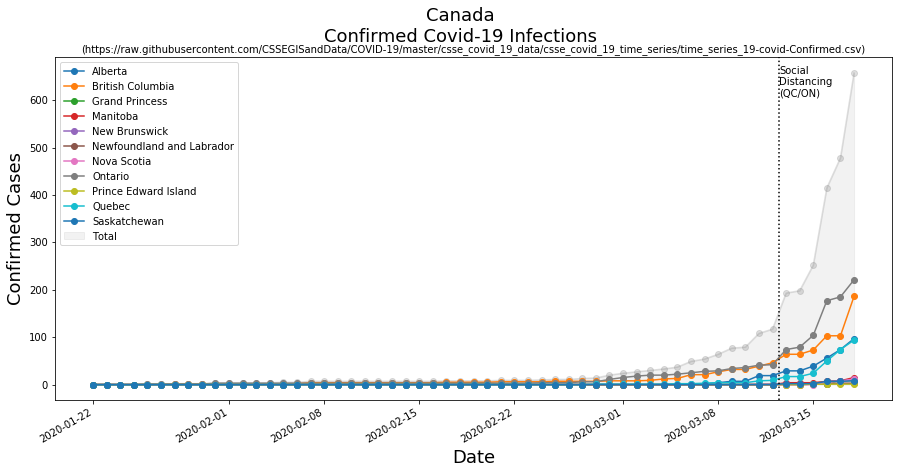

In [13]:
plt.figure(figsize=(15,7))
_t=plt.suptitle('{}\nConfirmed Covid-19 Infections'.format(country_name),fontsize=18)
_t=plt.title('({})'.format(raw_csv),fontsize=10)

plt.plot(t_x,t_y,'-o',color='grey',alpha=0.25)
plt.fill_between(t_x,t_y,interpolate=False,color='grey',alpha=0.1,label='Total')

if not df_p_is_total:
    for province in sort(unique(df_p['Province/State'])):
        df_pp = df_p[df_p['Province/State']==province]
        x = dateconvert(df_pp.iloc[:,col_start_idx+start_idx:].columns)
        y = np.squeeze(df_pp.iloc[:,col_start_idx+start_idx:])
        plt.plot(x,y,'o-',label=province)

#add the legend, but only if there are less than 20 lines on the plot
if len(unique(df_p['Province/State']))<=20: 
    plt.legend()
plt.gcf().autofmt_xdate()
_t=plt.xlabel("Date",fontsize=18)
_t=plt.ylabel("Confirmed Cases",fontsize=18)
if social_distancing_date is not None:
    _p=plt.axvline(x=social_distancing_date,color='k',linestyle=':')
    _t=plt.text(social_distancing_date,t_y.max()-50,"Social\nDistancing\n(QC/ON)")

In [14]:
# Grab most recent data and plot as a snapshot, hopefully with spatial information

most_recent_data = df.columns[-1]
df_country_lat_long = df[['Country/Region','Lat','Long',most_recent_data]]
# df_country_cases = df[['Country/Region',most_recent_data]]
# df_country_lat_long = df_country_lat_long.groupby('Country/Region',as_index=False).median()
df_country_lat_long = df_country_lat_long.groupby('Country/Region',
                                                  as_index=False).agg({'Lat':mean, 
                                                                       'Long':mean, 
                                                                       most_recent_data:sum}) #gives approximate location


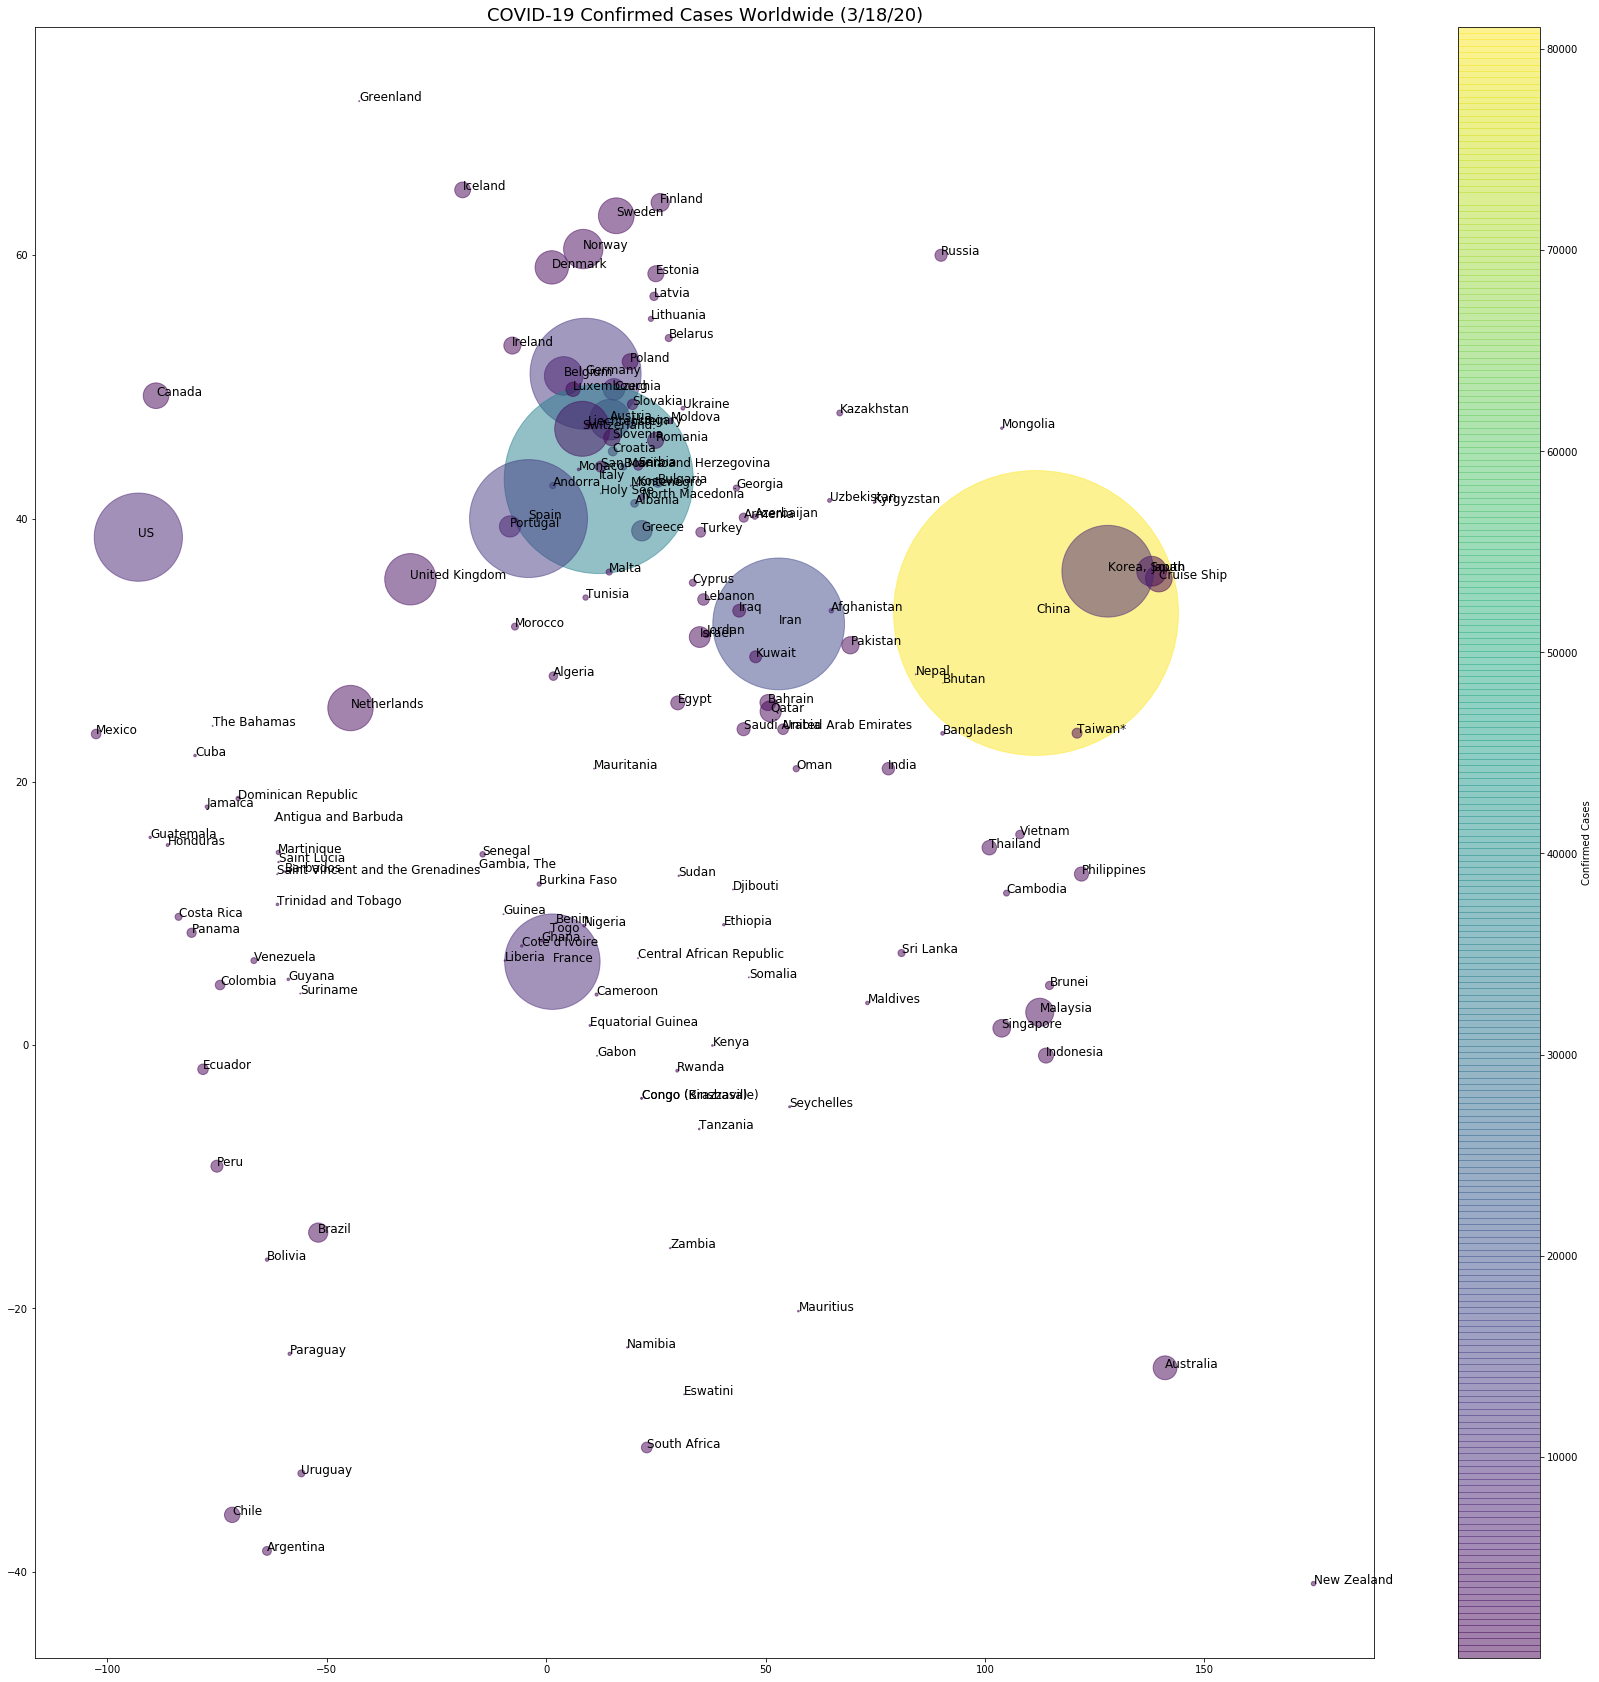

In [15]:
plt.figure(figsize=(30,30))
plt.title('COVID-19 Confirmed Cases Worldwide ({})'.format(most_recent_data),fontsize=18)
colors = df_country_lat_long[most_recent_data]/df_country_lat_long[most_recent_data].max()
plt.scatter(df_country_lat_long.Long,df_country_lat_long.Lat,
            s=df_country_lat_long[most_recent_data],c=df_country_lat_long[most_recent_data],
            cmap='viridis',alpha=.5)
cb = plt.colorbar(label='Confirmed Cases')
for country in df_country_lat_long['Country/Region']:
    x,y=df_country_lat_long[df_country_lat_long['Country/Region']==country][['Lat','Long']].values.flatten()
    plt.text(y,x,country,fontsize=12)

In [17]:
###### MORE UP TO DATE INFORMATION, but no lat/long so it will have to be merged with above df

In [18]:
from bs4 import BeautifulSoup
import urllib.request

url = 'https://www.worldometers.info/coronavirus/'
source = urllib.request.urlopen(url)
soup = BeautifulSoup(source,'html.parser')
table = soup.find('table',attrs={'id':"main_table_countries_today"})
table_rows = table.find_all('tr')

res = []
for tr in table_rows:
    #get the column names first
    if table_rows.index(tr) == 0:
        col_names = [ th.getText().strip() for th in tr.find_all('th') if th.getText().strip() != '' ]  
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td]
    if row:
        res.append(row)
df_current = pd.DataFrame(res,columns=col_names)
df_current.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop
0,China,"80,928",+34,"3,245",+8,"70,420","7,263","2,274",56
1,Italy,"41,035","+5,322","3,405",+427,"4,440","33,190","2,498",679
2,Iran,"18,407","+1,046","1,284",+149,"5,979","11,144",,219
3,Spain,"17,963","+3,194",830,+192,"1,107","16,026",800,384
4,Germany,"15,309","+2,982",44,+16,114,"15,151",2,183


In [ ]:
print(sort(df_current['Country,Other'].tolist()))

In [ ]:
thead = table.find_all('thead')
[th.text for th in thead]

In [ ]:
header = ['Country','Latitute','Longitude']
res = []
countries = []
for country in unique(df['Country/Region']):
    res.append(df[df['Country/Region'] == country][['Lat','Long']].mean())
    countries.append(country.strip("*").replace("S.","South").replace("St.","Saint"))

In [ ]:
countries